In [16]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader
import glob
import os
import pandas as pd
import getpass
import chromadb
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import OllamaEmbeddings

groq_api = os.getenv("GROQ_API_KEY")
openai_api = os.getenv("OPENAI_API_KEY")

embeddings = OllamaEmbeddings(model="llama3:70b")

# def load_knowledges(path='knowledges'):
def load_knowledges(path='trial'):
    docs = list()

    txt_files = glob.glob(f'{path}/*.txt')
    for txt in txt_files:
        loader = TextLoader(txt, autodetect_encoding=True)
        docs.extend(loader.load())
    pdf_files = glob.glob(f'{path}/*.pdf')
    for pdf in pdf_files:
        loader = PyPDFLoader(pdf)
        docs.extend(loader.load())

    return docs
docs = load_knowledges()

In [6]:
import matplotlib.pyplot as plt
import tiktoken

<function matplotlib.pyplot.show(close=None, block=None)>

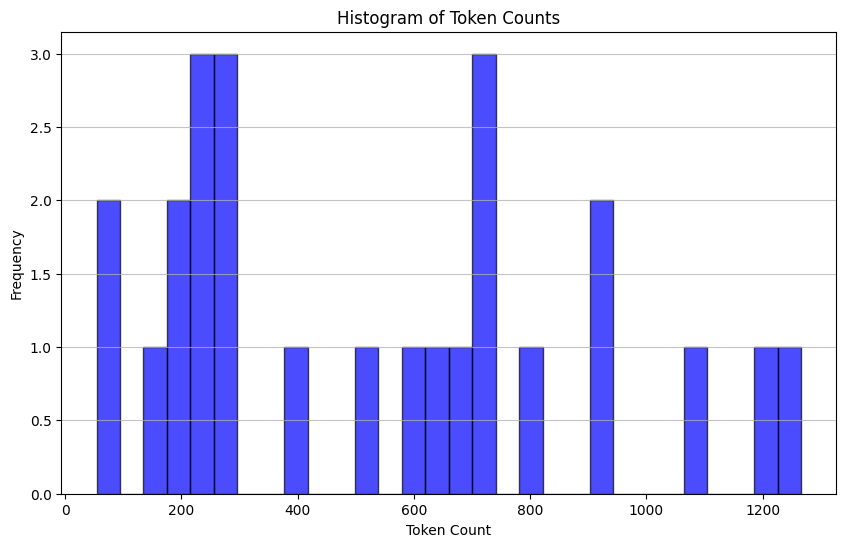

In [17]:
docs_texts = [d.page_content for d in docs]

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens
# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [18]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 13546


In [19]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

In [25]:
# from langchain_openai import OpenAIEmbeddings
# embd = OpenAIEmbeddings()

# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")


from langchain_community.embeddings import OllamaEmbeddings
embd = OllamaEmbeddings(model="llama3:8b")

from langchain_groq import ChatGroq
# model = ChatGroq(temperature=0, groq_api_key=groq_api, model_name="mixtral-8x7b-32768")
model = ChatGroq(temperature=0, groq_api_key=groq_api, model_name="llama3-70b-8192")

In [12]:
chat.invoke("siapa jokowi?")

AIMessage(content="Joko Widodo, commonly known as Jokowi, is an Indonesian politician who has been serving as the 7th President of Indonesia since 2014. He is the first Indonesian president from outside the military and political elite, and the first to come from a humble background.\n\nJokowi was born on June 21, 1961, in Surakarta, Central Java, Indonesia. He earned a degree in forestry engineering from Gadjah Mada University in Yogyakarta. Before entering politics, he worked as a furniture businessman and later became the mayor of Surakarta from 2005 to 2012.\n\nJokowi's political career began when he was elected as the governor of Jakarta in 2012, a position he held until 2014. During his tenure, he implemented various reforms and infrastructure projects, which earned him popularity among the people.\n\nIn 2014, Jokowi ran for president and won the election, defeating Prabowo Subianto. He was re-elected in 2019, again defeating Prabowo Subianto.\n\nAs president, Jokowi has focused 

In [28]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture
import time

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc. 
    
    LangChain Expression Language provides a way to compose chain in LangChain.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))
        time.sleep(180)

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [29]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 5 clusters--
--Generated 1 clusters--


In [30]:
from langchain_community.vectorstores import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [47]:
persist_directory = 'chroma'
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd, persist_directory=persist_directory)
retriever = vectorstore.as_retriever()

In [53]:
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embd)
retriever = vectordb.as_retriever()
docs = retriever.get_relevant_documents("jelaskan tentang alur pengajuan")
print(len(docs))

4


In [52]:
for i in range(4):
    print(docs[i])

page_content='FTMM Sumbangkan Sepeda Listrik Dalam Pengmas Penugasan di Gili Iyang\nMaret 31, 2023\n\nFTMM NEWS – Pengabdian Masyarakat penugasan solar panel shelter dan sepeda listrik Fakultas Teknologi Maju dan Multidisiplin (FTMM) Universitas Airlangga,  dilaksanakan di Pulau Gili Iyang, Madura. Pengmas di pulau yang dikenal punya kadar oksigen tinggi ini  membawa dua tema proyek yang diketuai oleh dosen Prodi Teknik Elektro FTMM. Salah satu tema tersebut adalah “Sepeda Listrik dan Solar Panel Shelter for E-Bike Charging sebagai sarana mobilitas tenaga kesehatan puskesmas di Pulau Gili Iyang, Sumenep” yang diketuai oleh dosen Yoga Uta Nugraha, S.T., M.T.\n\n“Kami menciptakan sepeda listrik untuk mendukung kebutuhan kegiatan tenaga medis di puskesmas pembantu Desa Bancamara,” tutur Yoga Uta selaku ketua pengmas penugasan. \n\nSepeda listrik yang diberikan kepada pustu Desa Bancamara memiliki kapasitas baterai 36 Volt sehingga dapat menempuh jarak yang lebih jauh. Selain itu, dilengka

In [46]:
retriever = vectorstore.as_retriever(search_kwargs={"k":k}, search_type="similarity")
print(retriever)

tags=['Chroma', 'OllamaEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000002CB3D02EE00> search_kwargs={'k': 'apa itu tsd'}


In [59]:
results[1][0]

,text,embd,cluster
0,Alur Pendaftaran Online Mahasiswa Baru\nUniver...,"[0.8100926280021667, -2.050239086151123, -3.89...",[0.0]
1,Alur Pengajuan Legalisir dan Transkrip Nilai\n...,"[-0.6305159330368042, -3.6862032413482666, -0....",[2.0]
2,Alur Pengajuan Surat Keterangan Mahasiswa Akti...,"[-0.48852279782295227, -3.747920274734497, -0....",[2.0]
3,Alur Pengajuan Surat Keterangan\n1. Mengunduh ...,"[-0.6441665291786194, -3.5860071182250977, -0....",[2.0]
4,Alur Pengajuan Surat Rekomendasi\n1. Mengunduh...,"[-0.5954611897468567, -3.529864549636841, -0.4...",[2.0]
5,BANGGA EV Charging Station Ikuti ASSIE 2023\nD...,"[1.7304898500442505, -0.9234911203384399, -0.8...",[1.0]
6,Biaya Pendaftaran\nBiaya pendaftaran Program S...,"[0.32990750670433044, -2.8176767826080322, -0....",[3.0]
7,Digitalisasi UMKM dan Pendidikan Berkualitas d...,"[-1.3228683471679688, -1.1161653995513916, -2....",[4.0]
8,Dosen Teknik Elektro Ciptakan Robot ARTA-1 unt...,"[-0.8411134481430054, -2.8027169704437256, -2....",[3.0]
9,Dosen Teknik Industri: SUVA Merupakan Teknolog...,"[-0.7128246426582336, -2.6415457725524902, -2....",[3.0]


In [58]:
results[1][0].to_csv('doc_cluster_trial.csv', index = False)

In [44]:
for i in range(5):
    print(results[1][1]["summaries"][i])
    print("=======")

The provided documentation appears to be a collection of unrelated texts, which makes it challenging to provide a detailed summary. However, I'll try to break down the content into sections and provide a brief overview of each:

**Section 1: Alur Pendaftaran Online Mahasiswa Baru**

This section provides a step-by-step guide for new students to register online at Universitas Airlangga. The process involves creating an account, filling out a registration form, uploading required documents, and making a payment.

**Section 2: FTMM News**

This section appears to be a news article about a community service project by the Faculty of Advanced Technology and Multidisciplinary (FTMM) at Universitas Airlangga. The project involves providing electric bicycles and solar panels to a health clinic on an island.

**Section 3: Partnership and Collaboration**

This section lists various partnerships and collaborations between Universitas Airlangga and other organizations, including companies and univ

In [45]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
rag_chain.invoke("jelaskan tentang tsd")

'TSD stands for Teknologi Air Tawar untuk Mendeteksi Karsinogenik Awal Sepanjang Bantaran Sungai, which is a technology for detecting carcinogenic substances in freshwater rivers.'